In [1]:
import numpy as np
import pandas as pd
import fiona
from shapely.geometry import shape, mapping
from GISio import shp2df, df2shp
import shapefile as sf

### read in a shapefile using `fiona`
more info here: https://github.com/Toblerity/Fiona  
`fiona` manual: http://toblerity.org/shapely/manual.html

In [2]:
shapefile = 'data/ZillowNeighborhoods-CA/ZillowNeighborhoods-CA.shp'
out_shapefile = 'data/scratch.shp'

with fiona.open(shapefile) as src:
    meta = src.meta
    records = []
    for line in src:
        props = line['properties']
        props['geometry'] = line.get('geometry', None)
        records.append(props)

In [3]:
src.meta

{'crs': {'init': 'epsg:4269'},
 'crs_wkt': 'GEOGCS["GCS_North_American_1983",DATUM["North_American_Datum_1983",SPHEROID["GRS_1980",6378137,298.257222101]],PRIMEM["Greenwich",0],UNIT["Degree",0.017453292519943295],AUTHORITY["EPSG","4269"]]',
 'driver': 'ESRI Shapefile',
 'schema': {'geometry': 'Polygon',
  'properties': OrderedDict([('State', 'str:80'),
               ('County', 'str:80'),
               ('City', 'str:80'),
               ('Name', 'str:80'),
               ('RegionID', 'str:80')])}}

#### Each record is a dictionary similar to the GeoJSON format

In [4]:
records[0]

OrderedDict([('State', 'CA'),
             ('County', 'Riverside'),
             ('City', 'Menifee'),
             ('Name', 'Sun City'),
             ('RegionID', '7314'),
             ('geometry',
              {'coordinates': [[(-117.1935499999999, 33.74306900000005),
                 (-117.1935729999999, 33.74198700000005),
                 (-117.19369999999992, 33.73596500000008),
                 (-117.18936799999994, 33.73584000000005),
                 (-117.18935499999992, 33.72862400000008),
                 (-117.18935399999992, 33.72801800000008),
                 (-117.18925499999995, 33.72163400000005),
                 (-117.18921699999993, 33.719152000000065),
                 (-117.18921699999993, 33.71860200000009),
                 (-117.18910699999992, 33.717250000000035),
                 (-117.18907999999993, 33.715738000000044),
                 (-117.18896999999993, 33.71498200000008),
                 (-117.18896999999993, 33.71418100000005),
                 (-

### Make a `DataFrame` of the records
* information on the geometric features is stored in a `'geometry'` column but is still in GeoJSON-style format
* convert geometries to `shapely` features so we can do stuff with them

In [5]:
df = pd.DataFrame(records)
df['geometry'] = [shape(g) for g in df.geometry]
df.head()

State       County           City           Name RegionID  \
0    CA    Riverside        Menifee       Sun City     7314   
1    CA  Santa Clara       San Jose         Alviso     8075   
2    CA        Marin     San Rafael  Santa Venetia    20357   
3    CA        Marin     San Rafael      Marinwood    25757   
4    CA  Los Angeles  Santa Clarita        Newhall    26134   

                                            geometry  
0  POLYGON ((-117.1935499999999 33.74306900000005...  
1  POLYGON ((-121.9423569999999 37.46496300000007...  
2  POLYGON ((-122.50308997 38.01594776500008, -12...  
3  POLYGON ((-122.56417078 38.02552641400007, -12...  
4  POLYGON ((-118.5364387599999 34.42379381100029...

### inspect an individual feature

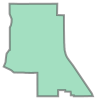

In [6]:
geom0 = df.geometry[0]
geom0

In [7]:
geom0.bounds

(-117.22712599999994,
 33.68503400000009,
 -117.17126599999995,
 33.74306900000005)

### since the geometries are `shapely` objects, there are many things we can do with them

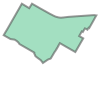

In [8]:
from shapely.affinity import rotate
rotate(geom0, 60.)

### Read in the same shapefile with a filter
* this can speed up reading from large datasets (such as NHDPlus) if only a subset of the features are needed

In [9]:
with fiona.open(shapefile) as src:
    meta = src.meta
    records = []
    for line in src.filter(bbox=(-124, 39, -122, 38)):
        props = line['properties']
        props['geometry'] = line.get('geometry', None)
        records.append(props)
    df2 = pd.DataFrame(records)
df2.head()

State County        City           Name RegionID  \
0    CA  Marin  San Rafael  Santa Venetia    20357   
1    CA  Marin  San Rafael      Marinwood    25757   
2    CA   Napa        Napa     Napa Abajo   116825   
3    CA   Napa        Napa   Stanly Ranch   118281   
4    CA  Marin      Novato      San Marin    23011   

                                            geometry  
0  {'type': 'Polygon', 'coordinates': [[(-122.503...  
1  {'type': 'Polygon', 'coordinates': [[(-122.564...  
2  {'type': 'Polygon', 'coordinates': [[(-122.293...  
3  {'type': 'Polygon', 'coordinates': [[(-122.284...  
4  {'type': 'Polygon', 'coordinates': [[(-122.589...

### Using `GIS_utils`
* `shp2df` is a macro around `fiona` and `shapely` that also handles null geometries, dbf files, boolean values, etc.

In [10]:
df = shp2df(shapefile)
df


reading data/ZillowNeighborhoods-CA/ZillowNeighborhoods-CA.shp...
--> building dataframe... (may take a while for large shapefiles)


State          County            City                         Name  \
0       CA       Riverside         Menifee                     Sun City   
1       CA     Santa Clara        San Jose                       Alviso   
2       CA           Marin      San Rafael                Santa Venetia   
3       CA           Marin      San Rafael                    Marinwood   
4       CA     Los Angeles   Santa Clarita                      Newhall   
5       CA     Los Angeles     Los Angeles                      Tujunga   
6       CA         Ventura          Oxnard                     Cabrillo   
7       CA     Los Angeles     Los Angeles                 Shadow Hills   
8       CA     Los Angeles     Los Angeles                       Sylmar   
9       CA   San Francisco   San Francisco                     Presidio   
10      CA     Los Angeles   Santa Clarita               Canyon Country   
11      CA         Alameda         Alameda                     East End   
12      CA       San Mateo         Belmont                     McDougal   
13      CA       Riverside         Menifee                     Romoland   
14      CA     Los Angeles     Los Angeles                   Sun Valley   
15      CA  San Bernardino  San Bernardino              Arrowhead Farms   
16      CA     Los Angeles     Los Angeles              North Hollywood   
17      CA           Marin     Mill Valley                      Almonte   
18      CA           Marin     Mill Valley                         Alto   
19      CA     Los Angeles     Los Angeles                      Bel Air   
20      CA     Los Angeles      Long Beach                Belmont Shore   
21      CA     Los Angeles     Los Angeles                 Beverly Glen   
22      CA     Santa Clara        San Jose                Cambrian Park   
23      CA         Alameda         Hayward                   Cherryland   
24      CA         Alameda         Oakland                    Chinatown   
25      CA     San Joaquin        Stockton                 Country Club   
26      CA       San Diego       San Diego              Del Mar Heights   
27      CA     Los Angeles     Los Angeles                   Eagle Rock   
28      CA     San Joaquin        Stockton                    Fair Oaks   
29      CA   San Francisco   San Francisco                Forest Knolls   
...    ...             ...             ...                          ...   
2021    CA            Napa            Napa                    Riverpark   
2022    CA            Napa            Napa                    Shurtleff   
2023    CA            Napa            Napa              Von Uhlit Ranch   
2024    CA            Napa            Napa           Springwood Estates   
2025    CA       San Mateo    Redwood City               Woodside Plaza   
2026    CA       San Mateo    Redwood City                      Sequoia   
2027    CA       San Mateo    Redwood City                 Greco Island   
2028    CA       San Mateo    Redwood City                  Bair Island   
2029    CA    Contra Costa        Richmond              Panhandle Annex   
2030    CA    Contra Costa        Richmond               Richmond Annex   
2031    CA    Contra Costa        Richmond         Carriage Hills North   
2032    CA    Contra Costa        Richmond               North and East   
2033    CA      Sacramento          Folsom                 Empire Ranch   
2034    CA      Sacramento          Folsom               Natoma Station   
2035    CA         Alameda         Alameda              Harbor Bay Isle   
2036    CA         Alameda         Alameda                  Ballena Bay   
2037    CA         Alameda         Alameda                 Bronze Coast   
2038    CA           Marin      San Rafael   Mont Marin/San Rafael Park   
2039    CA           Marin      San Rafael                  Peacock Gap   
2040    CA           Marin      San Rafael       Montecito/Happy Valley   
2041    CA           Marin      San Rafael                   Bret Harte   
2042    CA           Marin    

### Writing a `DataFrame` to a shapefile

#### make a schema
* since what we are writing out has the same structure as what we read in, we can recycle the schema. Otherwise, we'd have to make one.

In [11]:
src.meta['schema']

{'geometry': 'Polygon',
 'properties': OrderedDict([('State', 'str:80'),
              ('County', 'str:80'),
              ('City', 'str:80'),
              ('Name', 'str:80'),
              ('RegionID', 'str:80')])}

#### define the coordinate system (if you want a .prj file)
* we can also recycle this
* but this can also be easily made if the [**epsg code**](http://www.epsg.org/) is known

In [12]:
src.meta['crs']

{'init': 'epsg:4269'}

In [13]:
from fiona.crs import from_epsg
from_epsg(4269)

{'init': 'epsg:4269', 'no_defs': True}

#### convert the `DataFrame` back to a list of dictionaries

In [14]:
props = df.drop('geometry', axis=1).astype(object).to_dict(orient='records')
props[0:3]

[{'City': 'Menifee',
  'County': 'Riverside',
  'Name': 'Sun City',
  'RegionID': '7314',
  'State': 'CA'},
 {'City': 'San Jose',
  'County': 'Santa Clara',
  'Name': 'Alviso',
  'RegionID': '8075',
  'State': 'CA'},
 {'City': 'San Rafael',
  'County': 'Marin',
  'Name': 'Santa Venetia',
  'RegionID': '20357',
  'State': 'CA'}]

#### `shapely.geometry.mapping` converts the `shapely` objects back to GeoJSON
more about the geo_interface [here](https://gist.github.com/sgillies/2217756)

In [15]:
mapped = [mapping(g) for g in df.geometry]
mapped[0]

{'coordinates': (((-117.1935499999999, 33.74306900000005),
   (-117.1935729999999, 33.74198700000005),
   (-117.19369999999992, 33.73596500000008),
   (-117.18936799999994, 33.73584000000005),
   (-117.18935499999992, 33.72862400000008),
   (-117.18935399999992, 33.72801800000008),
   (-117.18925499999995, 33.72163400000005),
   (-117.18921699999993, 33.719152000000065),
   (-117.18921699999993, 33.71860200000009),
   (-117.18910699999992, 33.717250000000035),
   (-117.18907999999993, 33.715738000000044),
   (-117.18896999999993, 33.71498200000008),
   (-117.18896999999993, 33.71418100000005),
   (-117.18866899999995, 33.712829000000056),
   (-117.18855899999994, 33.71266900000006),
   (-117.18844899999993, 33.711959000000036),
   (-117.18817499999994, 33.71113400000007),
   (-117.1879449999999, 33.71056900000008),
   (-117.18770899999993, 33.709989000000064),
   (-117.18757899999991, 33.709771000000046),
   (-117.1873359999999, 33.70936400000005),
   (-117.18714099999994, 33.709039000

In [16]:
with fiona.collection(out_shapefile, "w", driver="ESRI Shapefile", 
                      crs=src.meta['crs'], schema=src.meta['schema']) as output:
    for i in range(len(props)):
        output.write({'properties': props[i],
                      'geometry': mapped[i]})

### Using `GIS_utils`
* the `df2shp` macro uses `fiona` to write a `DataFrame` to a shapefile, taking care of the schem, coordinate system, and formatting

In [17]:
df2shp(df, out_shapefile, epsg=4269)

writing data/scratch.shp...


### `Pyshp` is an alternative to `fiona` that is written in pure python (`fiona` uses the OGR library)
* does not handle coordinate system defintions (no prj files)  
* does not always work nicely with shapely objects
* also does not read stand-alone dbf files for some reason

In [18]:
src = sf.Reader(shapefile)
src.fields

[('DeletionFlag', 'C', 1, 0),
 ['State', 'C', 80, 0],
 ['County', 'C', 80, 0],
 ['City', 'C', 80, 0],
 ['Name', 'C', 80, 0],
 ['RegionID', 'C', 80, 0]]

In [19]:
geoms = [shape(s) for s in src.iterShapes()]
records = [tuple(r) + (geoms[i],) for i, r in enumerate(src.iterRecords())]
records[0]

('CA',
 'Riverside',
 'Menifee',
 'Sun City',
 '7314',
 <shapely.geometry.polygon.Polygon at 0x11e9c4630>)

In [20]:
src.fields

[('DeletionFlag', 'C', 1, 0),
 ['State', 'C', 80, 0],
 ['County', 'C', 80, 0],
 ['City', 'C', 80, 0],
 ['Name', 'C', 80, 0],
 ['RegionID', 'C', 80, 0]]

In [21]:
columns = [f[0] for f in src.fields[1:]] + ['geometry'] # discard the DeletionFlag field (not in records)
df = pd.DataFrame(records, columns=columns)
df.head()

State       County           City           Name RegionID  \
0    CA    Riverside        Menifee       Sun City     7314   
1    CA  Santa Clara       San Jose         Alviso     8075   
2    CA        Marin     San Rafael  Santa Venetia    20357   
3    CA        Marin     San Rafael      Marinwood    25757   
4    CA  Los Angeles  Santa Clarita        Newhall    26134   

                                            geometry  
0  POLYGON ((-117.1935499999999 33.74306900000005...  
1  POLYGON ((-121.9423569999999 37.46496300000007...  
2  POLYGON ((-122.50308997 38.01594776500008, -12...  
3  POLYGON ((-122.56417078 38.02552641400007, -12...  
4  POLYGON ((-118.5364387599999 34.42379381100029...

### Writing with `pyshp`

#### specify the shape type
see https://en.wikipedia.org/wiki/Shapefile (scroll down to Shape Types table)
* get the shape type from a feature in the `geometry` column (we're assuming that they are all the same type, as required by the shapefile format)

In [22]:
types = {'Polygon': 5,
         'LineString': 3,
         'Point': 1}
geomtype = types[df.geometry[0].type]
geomtype

5

#### instantiate the shapefile writer

In [23]:
w = sf.Writer(geomtype)
w.autoBalance = 1 # prevents mismatch between number of features and records

#### rename the fields if necessary to enforce the 10-character limit

In [24]:
def enforce_10ch_limit(names):
    """Enforce 10 character limit for fieldnames.
    Add suffix for duplicate names starting at 0.

    Parameters
    ----------
    names : list of strings

    Returns
    -------
    names : list of unique strings of len <= 10.
    """
    names = [n[:9]+'1' if len(n) > 10 else n
             for n in names]
    dups = {x:names.count(x) for x in names}
    suffix = {n: list(range(len(cnt))) for n, cnt in dups.items() if cnt > 1}
    for i, n in enumerate(names):
        if dups[n] > 1:
            names[i] = n[:9] + str(suffix[n].pop(0))
    return names

# version of the dataframe without the geometry column
dfr = df.drop('geometry', axis=1)

names = enforce_10ch_limit(dfr.columns)
names

['State', 'County', 'City', 'Name', 'RegionID']

#### Specify dtypes and write the fields

In [25]:
def get_pyshp_field_info(dtypename):
    """Get pyshp dtype information for a given numpy dtype."""
    fields = {'int': ('N', 20, 0),
              '<i': ('N', 20, 0),
              'float': ('F', 20, 12),
              '<f': ('F', 20, 0),
              'bool': ('L', 1),
              'b1': ('L', 1),
              'str': ('C', 50),
              'object': ('C', 50)}
    k = [k for k in fields.keys() if k in dtypename.lower()]
    if len(k) == 1:
        return fields[k[0]]
    else:
        return fields['str']

In [26]:
for i, npdtype in enumerate(dfr.dtypes):
    w.field(names[i], *get_pyshp_field_info(npdtype.name))

#### write out the features and records, handling the different shapetypes

In [27]:
g = df.geometry[0]
mapping(g)['coordinates']

(((-117.1935499999999, 33.74306900000005),
  (-117.1935729999999, 33.74198700000005),
  (-117.19369999999992, 33.73596500000008),
  (-117.18936799999994, 33.73584000000005),
  (-117.18935499999992, 33.72862400000008),
  (-117.18935399999992, 33.72801800000008),
  (-117.18925499999995, 33.72163400000005),
  (-117.18921699999993, 33.719152000000065),
  (-117.18921699999993, 33.71860200000009),
  (-117.18910699999992, 33.717250000000035),
  (-117.18907999999993, 33.715738000000044),
  (-117.18896999999993, 33.71498200000008),
  (-117.18896999999993, 33.71418100000005),
  (-117.18866899999995, 33.712829000000056),
  (-117.18855899999994, 33.71266900000006),
  (-117.18844899999993, 33.711959000000036),
  (-117.18817499999994, 33.71113400000007),
  (-117.1879449999999, 33.71056900000008),
  (-117.18770899999993, 33.709989000000064),
  (-117.18757899999991, 33.709771000000046),
  (-117.1873359999999, 33.70936400000005),
  (-117.18714099999994, 33.709039000000075),
  (-117.18696899999992, 33.7

In [28]:
geoms = df.geometry.tolist()
props = dfr.astype(object).values

### write the geometry and attributes for each record
this gets tricky when there are MultiPolygons or other more complex geometry types
some code examples relevant to this issue:
https://gis.stackexchange.com/questions/52705/how-to-write-shapely-geometries-to-shapefiles  
https://gis.stackexchange.com/questions/209886/shapefile-structure-of-multipolygon  

In [29]:
# write the geometry and attributes for each record
if geomtype == 5:
    for i, r in enumerate(props):
        #g = geoms[i]
        w.poly(mapping(geoms[i])['coordinates'])
        #w.poly(list(map(list, mapping(g)['coordinates'])))
        w.record(*r)
elif geomtype == 3:
    for i, r in enumerate(props):
        w.line(mapping(geoms[i])['coordinates'])
        w.record(*r)
elif geomtype == 1:
    for i, r in enumerate(props):
        w.point((mapping(geoms[i])['coordinates']))
        w.record(*r)
w.save(out_shapefile)

AttributeError: 'tuple' object has no attribute 'append'

In [ ]:
i

In [ ]:
geoms[i].type

In [ ]:
geoms[i]

In [ ]:
list(g.geoms)